In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import re
import csv
import torch
import yaml
import sys
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy.stats import loguniform
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
X = pd.read_csv('../data/processed/vegf_augmented_processed.csv', index_col = 'Sequence')
y = pd.read_csv('../data/raw/VEGF_augmented_y.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state =4, stratify=y_train)

In [4]:
def modelfit(alg, dtrain, predictors,target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=target.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval =False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], target)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(target.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(target, dtrain_predprob))
                    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')

In [5]:
target = y_train.copy()
assert isinstance(target, pd.DataFrame), "df needs to be a pd.DataFrame"
target.dropna(inplace=True)
indices_to_keep = ~target.isin([np.nan, np.inf, -np.inf]).any(axis=1)
target[indices_to_keep].astype(np.int32)

,Label
7275,0
5612,0
6602,0
4852,1
1044,1
...,...
3509,1
1580,1
6386,0
6500,0


In [6]:
#Choose all predictors except target & IDcols

predictors = [x for x in X_train.columns]
xgb1 = XGBClassifier(
 learning_rate =1e-5,
 n_estimators=1000,
 max_depth=100,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 booster='gblinear',
 device = 'cuda')
modelfit(xgb1, X_train, predictors, y_train)

c:\tmp_cases\DEV\git\advance_drug_discovery\Advanced_drug_discovery\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:14:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
c:\tmp_cases\DEV\git\advance_drug_discovery\Advanced_drug_discovery\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:14:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
c:\tmp_cases\DEV\git\advance_drug_discovery\Advanced_drug_discovery\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:15:00] WARNING: C:\buildki


Model Report
Accuracy : 0.8354
AUC Score (Train): 0.945065


In [7]:
predict_val = xgb1.predict(X_val)


In [8]:
predict_val

array([1, 1, 1, ..., 1, 1, 0])

In [9]:
val_report = classification_report(y_val, predict_val, target_names=['positive','negative'])
print(val_report)

              precision    recall  f1-score   support

    positive       0.95      0.56      0.71       430
    negative       0.82      0.98      0.89       861

    accuracy                           0.84      1291
   macro avg       0.88      0.77      0.80      1291
weighted avg       0.86      0.84      0.83      1291



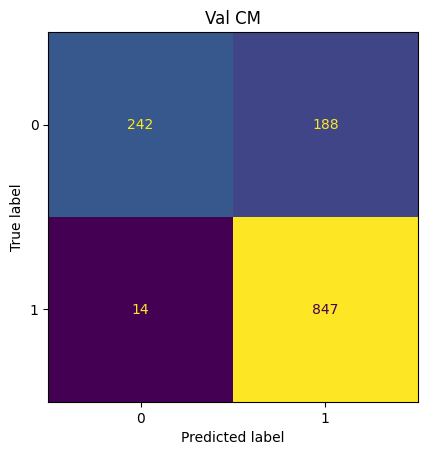

In [10]:
cm_val = confusion_matrix(y_val, predict_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp.plot(colorbar=False)
disp.ax_.set_title('Val CM')
plt.show()

In [13]:
predict_test = xgb1.predict(X_test)

In [14]:
test_report = classification_report(y_test, predict_test, target_names=['positive','negative'])
print(test_report)

              precision    recall  f1-score   support

    positive       0.95      0.53      0.68      1719
    negative       0.81      0.99      0.89      3442

    accuracy                           0.83      5161
   macro avg       0.88      0.76      0.78      5161
weighted avg       0.85      0.83      0.82      5161



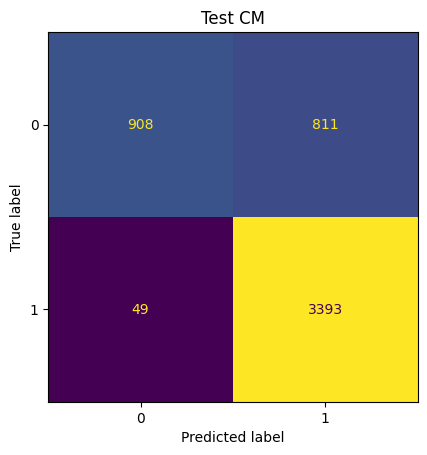

In [15]:
cm_test = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(colorbar=False)
disp.ax_.set_title('Test CM')
plt.show()

# Random search

In [16]:
# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

In [37]:
# Definir el diccionario de hiperparámetros
xgb_params = dict(
              learning_rate = np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000),
              num_boost_round= np.linspace(1000, 5000, num=100).astype(int),
              max_depth=np.linspace(1, 50, num= 1).astype(int),
              nfold = np.linspace(1, 50, num= 1).astype(int),
           #   early_stopping_rounds = np.linspace(1, 100, num= 10).astype(int),
              booster = ['gbtree', 'gblinear', 'dart']
            
              )

In [40]:
          
              
xgtrain = xgb.DMatrix(X_train[predictors].values, label=target.values)              
xgb_model = XGBClassifier(device = 'cuda')

# Configurar RandomizedSearchCV
n_iter_search = 15
xgb_random_search = RandomizedSearchCV(
    xgb_model, param_distributions=xgb_params, n_iter=n_iter_search, scoring='roc_auc',cv=5,verbose=3)


# Ajustar el modelo
start_time = time.time()
xgb_random_search.fit(X_train,y_train)
end_time = time.time()
xgb_fit_time = end_time - start_time

print(f"Tiempo de ajuste del modelo: {xgb_fit_time} segundos")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gblinear, learning_rate=0.0059847785117952135, max_depth=1, nfold=1, num_boost_round=3262;, score=0.980 total time=   0.5s
[CV 2/5] END booster=gblinear, learning_rate=0.0059847785117952135, max_depth=1, nfold=1, num_boost_round=3262;, score=0.975 total time=   0.5s
[CV 3/5] END booster=gblinear, learning_rate=0.0059847785117952135, max_depth=1, nfold=1, num_boost_round=3262;, score=0.982 total time=   0.5s
[CV 4/5] END booster=gblinear, learning_rate=0.0059847785117952135, max_depth=1, nfold=1, num_boost_round=3262;, score=0.978 total time=   0.5s
[CV 5/5] END booster=gblinear, learning_rate=0.0059847785117952135, max_depth=1, nfold=1, num_boost_round=3262;, score=0.971 total time=   0.6s
[CV 1/5] END booster=gblinear, learning_rate=0.043642633119241894, max_depth=1, nfold=1, num_boost_round=3262;, score=0.990 total time=   0.5s
[CV 2/5] END booster=gblinear, learning_rate=0.043642633119241894, max_depth

In [41]:
xgb_random_search.best_estimator_

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.4100944749601101), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(1), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              nfold=np.int64(1), num_boost_round=np.int64(2898), ...)

In [42]:
xgb_random_search.scorer_

make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba'))

In [43]:
# Predice valores de y
y_predict_xgb_train = xgb_random_search.predict(X_train)
y_predict_xgb_val = xgb_random_search.predict(X_val)
y_predict_xgb_test = xgb_random_search.predict(X_test)

# Calcula la precisión
accuracy_xgb_train = accuracy_score(y_train,y_predict_xgb_train)
accuracy_xgb_val = accuracy_score(y_val,y_predict_xgb_val)
accuracy_xgb_test = accuracy_score(y_test,y_predict_xgb_test)

print(f'Accuracy train {accuracy_xgb_train}')
print(f'Accuracy val {accuracy_xgb_val}')
print(f'Accuracy test {accuracy_xgb_test}')

Accuracy train 0.9804711717296962
Accuracy val 0.9821843532145623
Accuracy test 0.9800426273977911


In [44]:
print(classification_report(y_train, y_predict_xgb_train, target_names=['positive','negative']))
print(classification_report(y_val,   y_predict_xgb_val, target_names=['positive','negative']))
print(classification_report(y_test,  y_predict_xgb_test, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.98      0.96      0.97      2149
    negative       0.98      0.99      0.99      4303

    accuracy                           0.98      6452
   macro avg       0.98      0.98      0.98      6452
weighted avg       0.98      0.98      0.98      6452

              precision    recall  f1-score   support

    positive       0.99      0.96      0.97       430
    negative       0.98      0.99      0.99       861

    accuracy                           0.98      1291
   macro avg       0.98      0.98      0.98      1291
weighted avg       0.98      0.98      0.98      1291

              precision    recall  f1-score   support

    positive       0.98      0.96      0.97      1719
    negative       0.98      0.99      0.99      3442

    accuracy                           0.98      5161
   macro avg       0.98      0.98      0.98      5161
weighted avg       0.98      0.98      0.98      5161



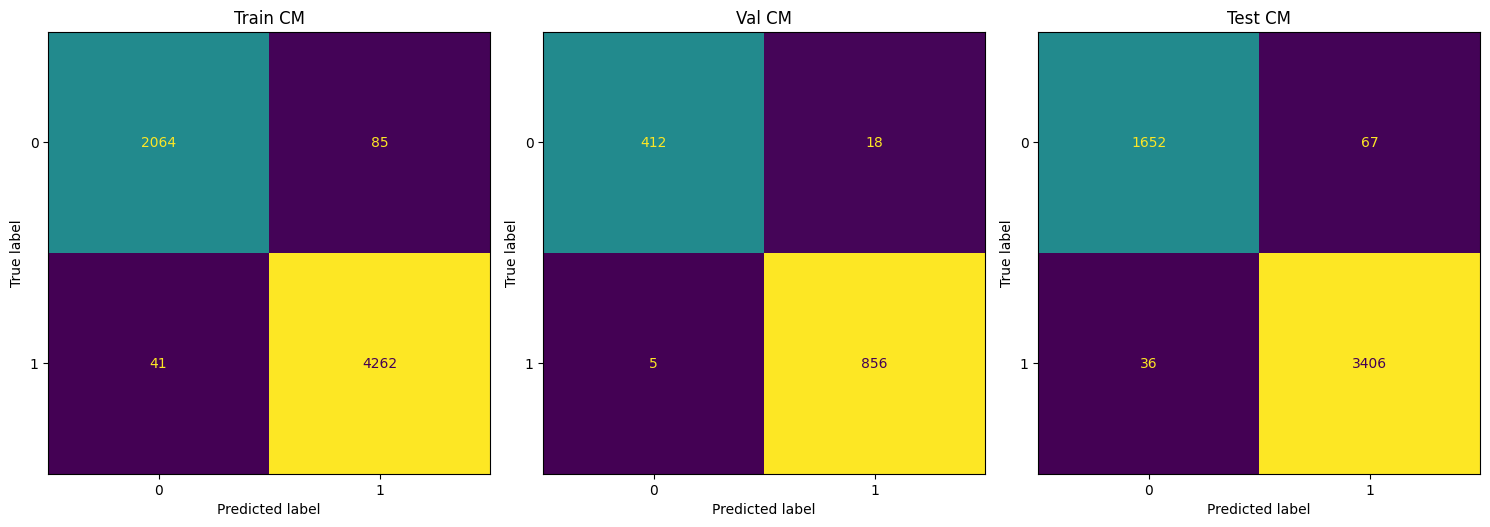

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Matriz de confusión para el conjunto de entrenamiento
cm_xgb_train = confusion_matrix(y_train, y_predict_xgb_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_train)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Train CM')

# Matriz de confusión para el conjunto de validación
cm_xgb_val = confusion_matrix(y_val, y_predict_xgb_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_val)
disp.plot(ax=axes[1], colorbar=False)
axes[1].set_title('Val CM')

# Matriz de confusión para el conjunto de prueba
cm_xgb_test = confusion_matrix(y_test, y_predict_xgb_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_test)
disp.plot(ax=axes[2], colorbar=False)
axes[2].set_title('Test CM')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()
